В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде __класифікувати__ товари із датасету `fasion_mnist`.

Вам належить запропонувати свою власну архітектуру мережі. Точність найнаївнішої, але адекватної нейромережі становить приблизно __91%__. Точність вашої моделі повинна бути `не нижчою` за цей показник. Щоб досягти таких значень вам знадобиться `поекспериментувати з гіперпараметрами мережі`:

- кількість шарів;

- кількість нейронів;

- функції активації;

- кількість епох;

- розмір батчу;

- вибір оптимізатора;

- різні техніки регуляризації і т.д.

Використайте вивчені `техніки виявлення проблем навчання` нейронної мережі, і потім `поекспериментуйте`.

Рішення оформіть у вигляді окремого ноутбука.

In [1]:
import itertools
from typing import Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import mish, relu, sigmoid, softmax
from tensorflow.keras.datasets import fashion_mnist
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
from keras import metrics
from keras import optimizers


2023-07-31 22:47:29.052851: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-31 22:47:29.069006: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 22:47:29.229302: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 22:47:29.231052: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 22:47:30.035682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

###### __Dataset__

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train.dtype, x_train[0].shape

(dtype('uint8'), (28, 28))

In [3]:
NUM_FEATURES = x_train[0].shape[0] * x_train[0].shape[1]

In [4]:
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# each sample (28x28) to 1x784
x_train, x_test = x_train.reshape([-1, NUM_FEATURES]), x_test.reshape([-1, NUM_FEATURES])
print(min(x_train.min(), x_test.min()))
maximum = max(x_train.max(), x_test.max()) # np.max([x_train.max(), x_test.max()]) 
maximum

0.0


255.0

In [5]:
# Normalize (min = 0)
x_train, x_test = x_train / maximum, x_test / maximum

In [6]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [7]:
max(y_train.max(), y_test.max()), min(y_train.min(), y_test.min())

(9, 0)

In [8]:
NUM_CLASSES = len(set(np.concatenate((y_train, y_test), axis=0)))
NUM_CLASSES

10

In [9]:
y_true = tf.one_hot(y_train, depth=NUM_CLASSES).numpy()
y_truev = tf.one_hot(y_test, depth=NUM_CLASSES).numpy()
y_true.shape, y_truev.shape

((60000, 10), (10000, 10))

###### __Model__

- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy

In [24]:
# number of hidden layers
n_layers = [el for el in range(1, 3)]  # 1, 2
n_of_neurons = [2**el for el in range(1, 8)] # [[2**el for el in range(1, 9)] for _ in n_layers]  # 7

activations = ['relu', 'sigmoid', 'softmax']  # 'mish',

optimizators = [optimizers.legacy.SGD, optimizers.legacy.RMSprop, optimizers.legacy.Adam]  # 3
learning_rates = [10**el for el in range(-3, -1)]  # 2
n_epoch = 100  # max limit
batch_sizes = [2**el for el in range(7, 10)]  # 3



In [18]:
n_hiddens_ = []
bundle_activations  = []
for s in n_layers:
    for el in list(itertools.product(n_of_neurons, repeat=s)):
        n_hidden_i = []
        n_hidden_i.append(NUM_FEATURES)
        n_hidden_i.extend(el)
        n_hidden_i.append(NUM_CLASSES)

        n_hiddens_.append(n_hidden_i)

    for el in list(itertools.product(activations[:-1], repeat=s)):
        activat = []
        activat.extend(el)
        activat.append(activations[-1])

        bundle_activations.append(activat)
    

In [19]:
len(n_hiddens_), len(bundle_activations)

(56, 6)

In [21]:
cx = 0
for set_layers in n_hiddens_:  # 584
    for act in bundle_activations:  # 39
        if len(set_layers) == (len(act) + 1):
            cx+=1

cx

210

In [44]:
def create_NN(n_hidden_: list, activation: list, optimizer=optimizers.SGD, learning_rate=0.1) -> Sequential:
    model = Sequential(name=f'''m-{''.join(map(str, [f'{i}-' for i in n_hidden_[1:-1]]))}{''.join(map(str, [f'{a}-' for a in activation[:-1]]))}{optimizer.__name__}-{learning_rate}''')
    n_layers = len(n_hidden_)
    for layer in range(1, n_layers):
        model.add(Dense(n_hidden_[layer], activation=activation[layer-1], input_shape=(n_hidden_[layer-1],)))

    model.compile(
                  optimizer=optimizer(learning_rate=learning_rate), # legacy
                  loss=losses.CategoricalCrossentropy(),  # 'categorical_crossentropy' losses.binary_crossentropy,
                  metrics=['accuracy']  # metrics.BinaryAccuracy()
                  )

    return model

In [45]:
models = []  # 9216  # !!! more then 32 GB RAM!!!!, ... try 1260 = 28sec
for set_layers in n_hiddens_:  # 584
    for act in bundle_activations:  # 39
        if len(set_layers) == (len(act) + 1):  # 1024  -> 210
            for opt in optimizators:  # 3
                for lr in learning_rates:  # 2
                    models.append(create_NN(n_hidden_=set_layers, activation=act, optimizer=opt, learning_rate=lr))

In [46]:
models[0].name

'm-2-relu-SGD-0.001'

###### __Training__

In [47]:
history = {}  # 27648 = 38+ days training
lucky_numbers = np.random.randint(1, len(models), size=5)
for num, model in enumerate(models):
    if num in lucky_numbers:
        for bs in batch_sizes:  # 3
            history[f'{model.name}({bs})'] = model.fit(
                                                        x_train,
                                                        y_true,
                                                        epochs=100,
                                                        batch_size=bs,
                                                        validation_data=(x_test, y_truev)
                                                        )

Epoch 1/100
469/469 [==============================] - 1s 2ms/step - loss: 2.2409 - accuracy: 0.1924 - val_loss: 2.1696 - val_accuracy: 0.3144
Epoch 2/100
469/469 [==============================] - 1s 2ms/step - loss: 2.0854 - accuracy: 0.3401 - val_loss: 2.0010 - val_accuracy: 0.3557
Epoch 3/100
469/469 [==============================] - 1s 2ms/step - loss: 1.9153 - accuracy: 0.3785 - val_loss: 1.8369 - val_accuracy: 0.3875
Epoch 4/100
469/469 [==============================] - 1s 2ms/step - loss: 1.7538 - accuracy: 0.4093 - val_loss: 1.6795 - val_accuracy: 0.4223
Epoch 5/100
469/469 [==============================] - 1s 2ms/step - loss: 1.5962 - accuracy: 0.4302 - val_loss: 1.5296 - val_accuracy: 0.4154
Epoch 6/100
469/469 [==============================] - 1s 1ms/step - loss: 1.4664 - accuracy: 0.4360 - val_loss: 1.4301 - val_accuracy: 0.4639
Epoch 7/100
469/469 [==============================] - 1s 2ms/step - loss: 1.3882 - accuracy: 0.4466 - val_loss: 1.3696 - val_accuracy: 0.4663

###### __Error Analysis__

In [204]:
# print(history[0].history.keys())
""" 
loss - список, в якому зберігається історія змін помилки на навчальних даних залежно від епохи
val_loss - список, де зберігається історія змін помилки на тестових даних залежно від епохи
accuracy - список, в якому зберігається історія змін точності на навчальних даних залежно від епохи
val_accuracy - список, де зберігається історія змін точності на тестових даних залежно від епохи
"""

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


' \nloss - список, в якому зберігається історія змін помилки на навчальних даних залежно від епохи\nval_loss - список, де зберігається історія змін помилки на тестових даних залежно від епохи\naccuracy - список, в якому зберігається історія змін точності на навчальних даних залежно від епохи\nval_accuracy - список, де зберігається історія змін точності на тестових даних залежно від епохи\n'

In [48]:
def draw_2twin_2d(y00: np.array, y01: np.array, y10: np.array, y11: np.array, suptitle: str) -> None:
    x = range(1, len(y00) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))

    axs[0].plot(x, y00, 'bo', label='Training loss')
    axs[0].plot(x, y01, 'g', label='Validation loss')
    axs[0].title.set_text('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(x, y10, 'bo', label='Training acc')
    axs[1].plot(x, y11, 'g', label='Validation acc')
    axs[1].title.set_text('Training and validation acc')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Acc')
    axs[1].legend()
    axs[1].grid()
    
    fig.suptitle(suptitle)
    # plt.legend()
    # plt.grid()
    axs[1].grid()
    plt.show()


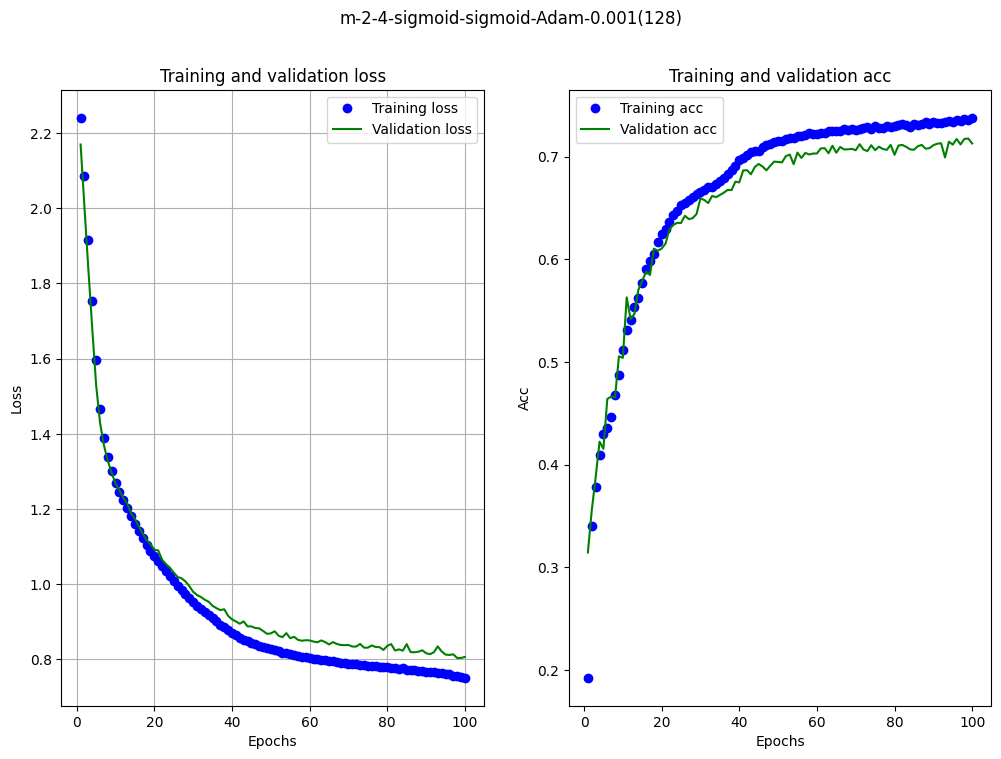

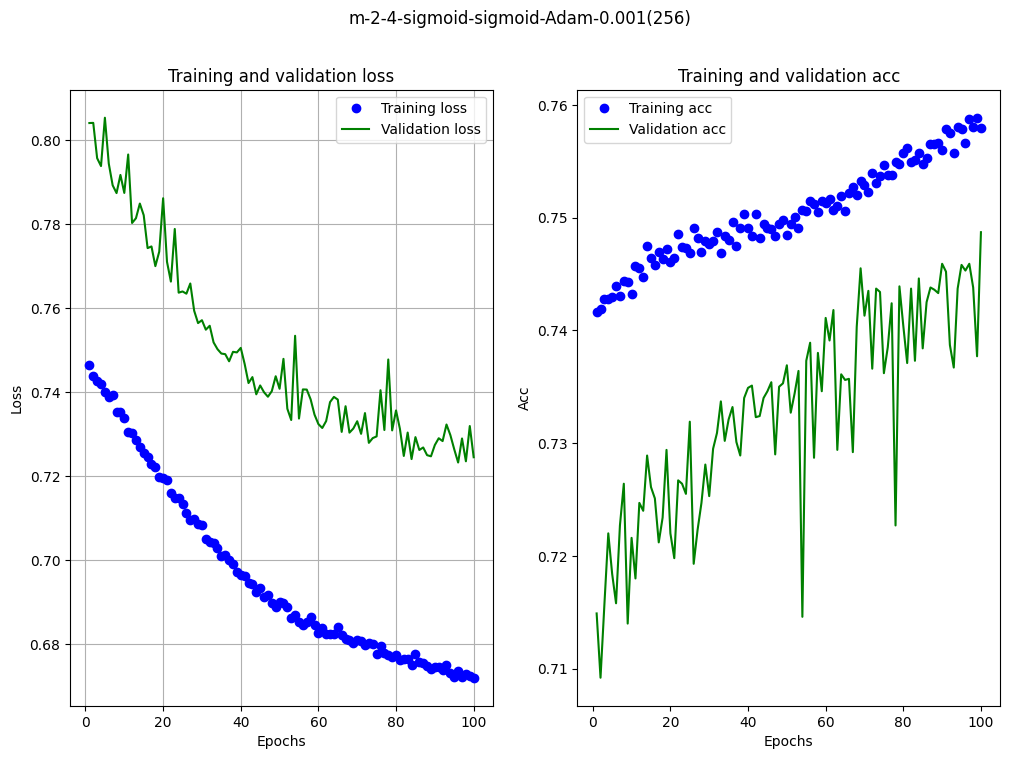

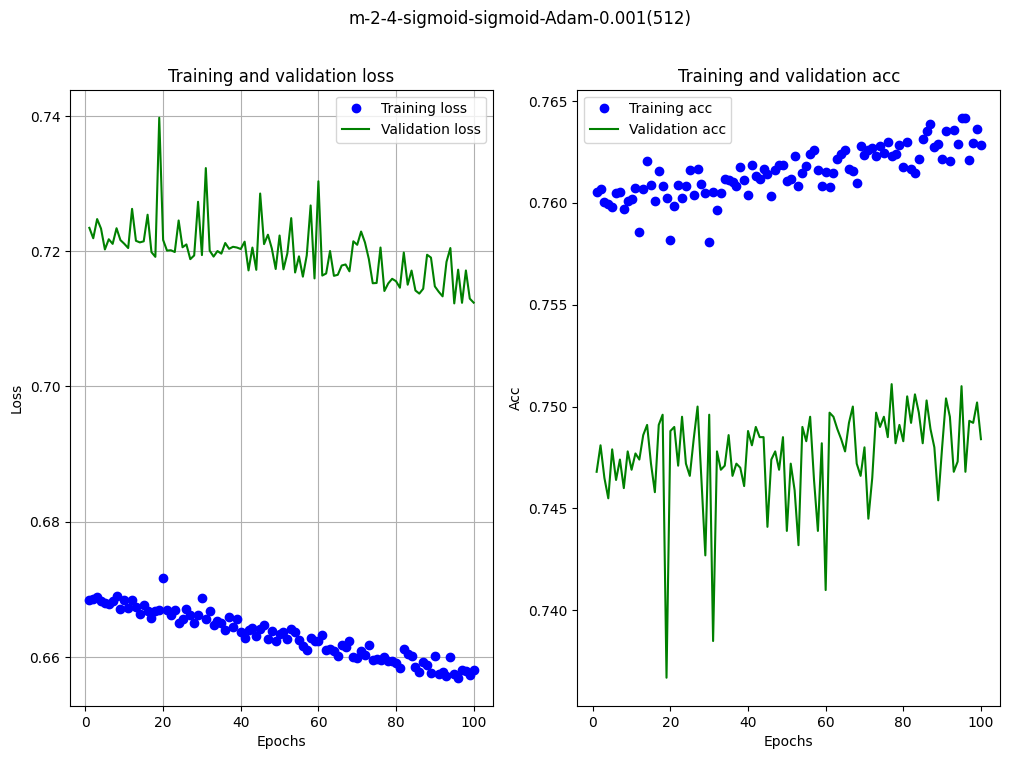

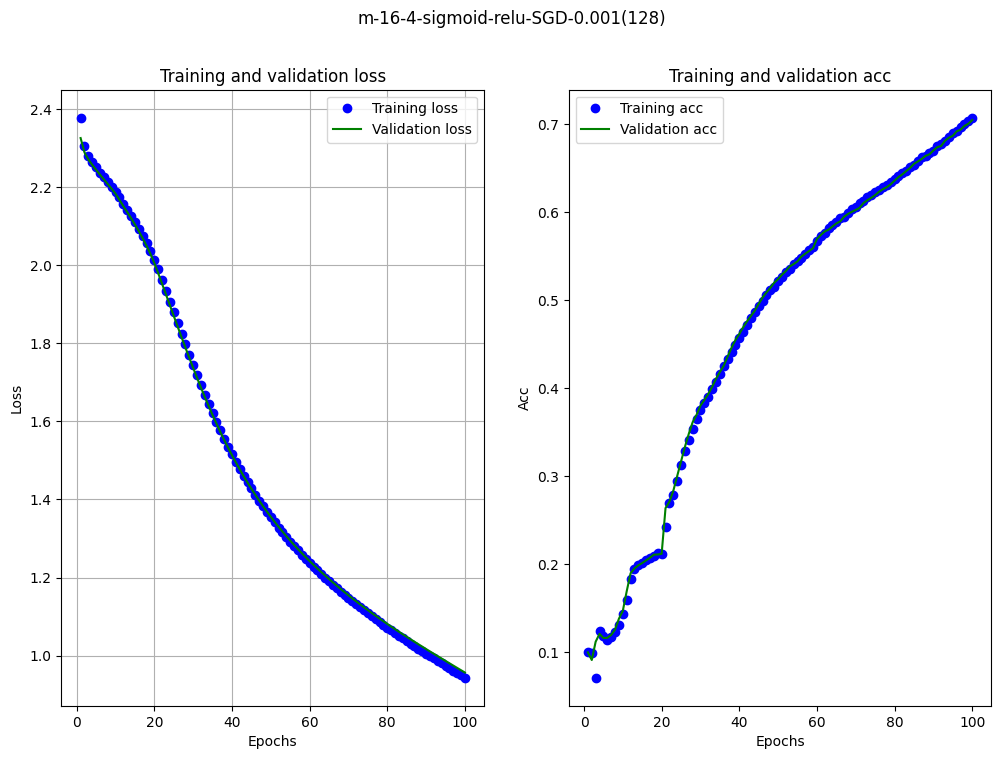

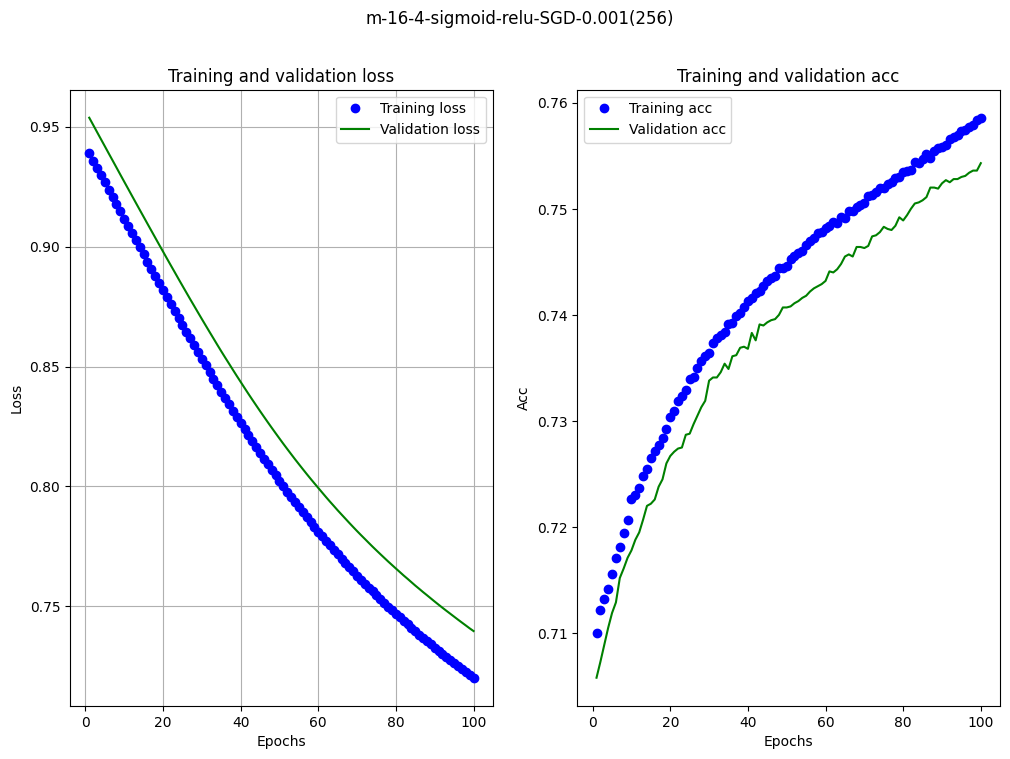

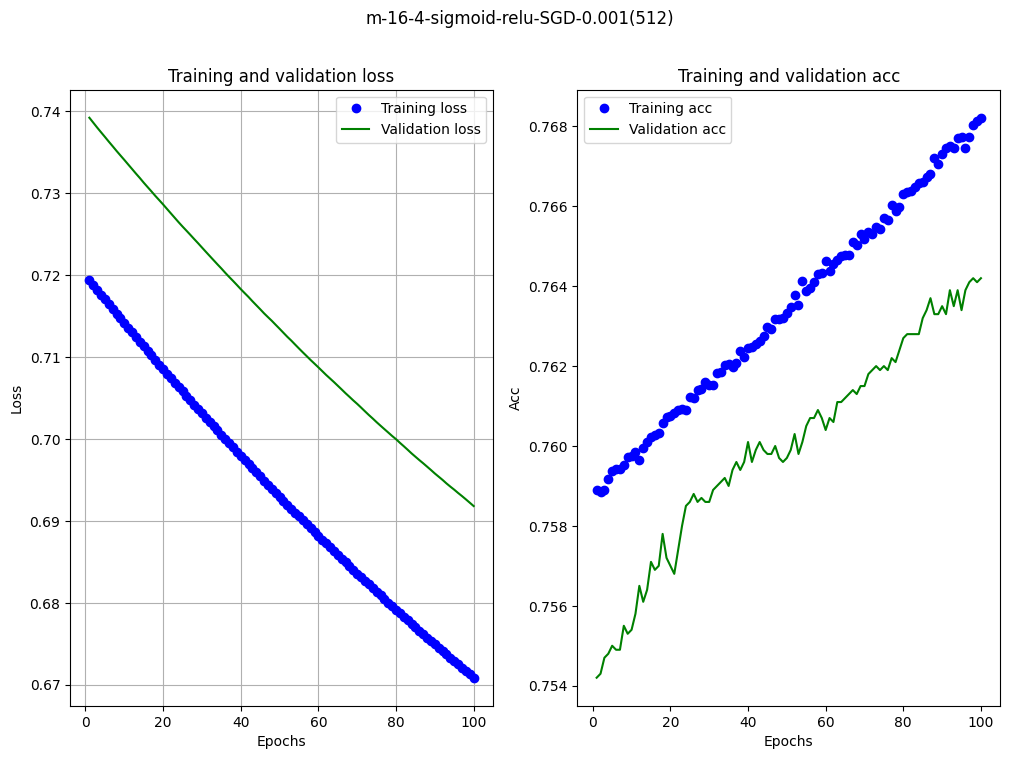

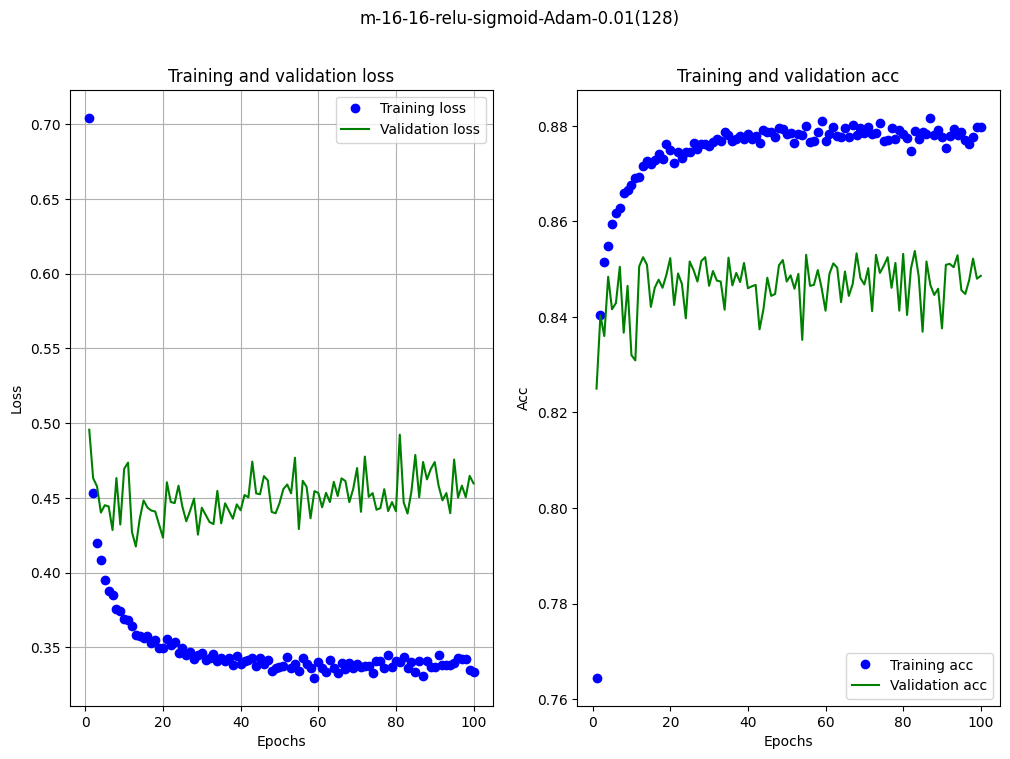

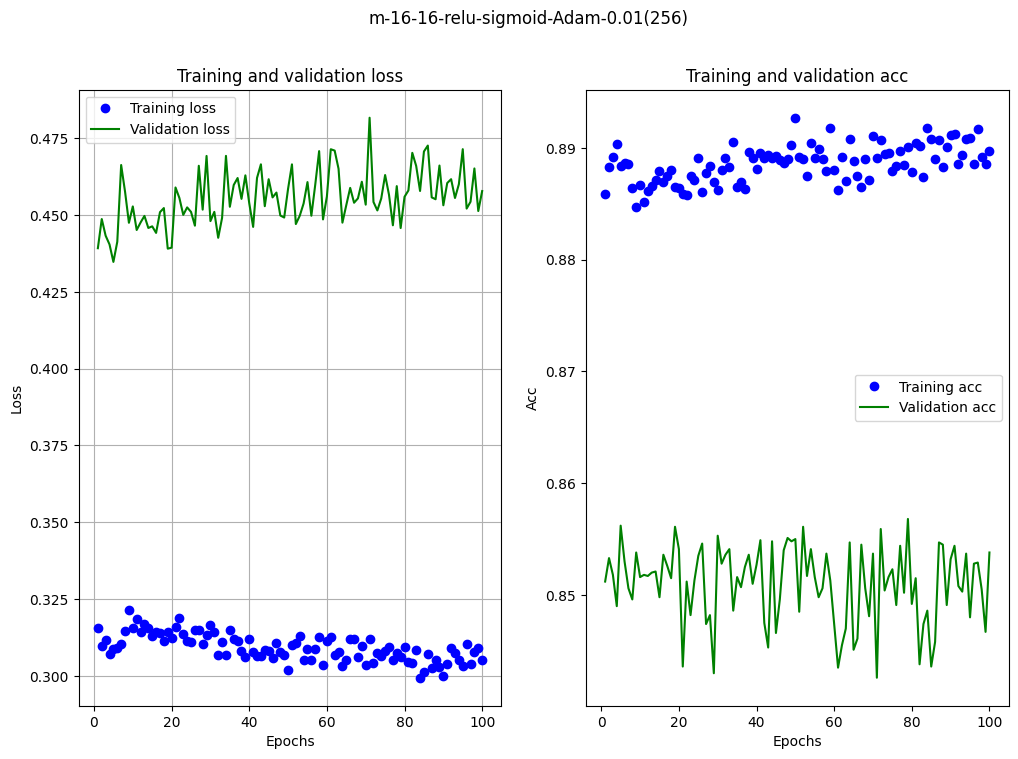

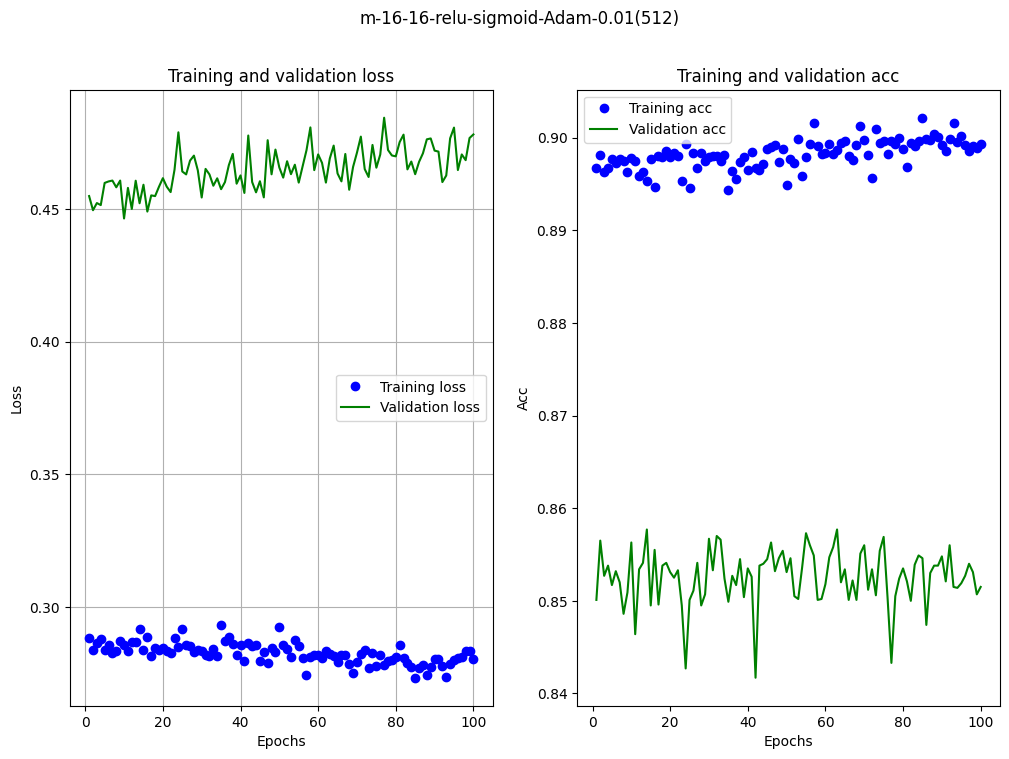

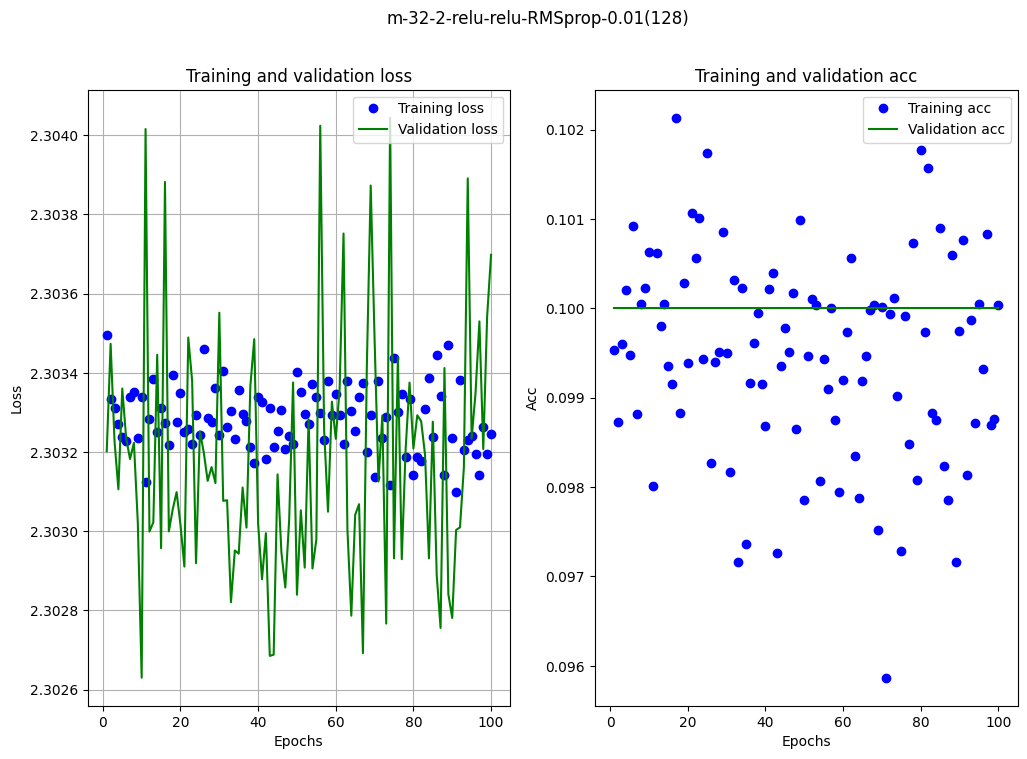

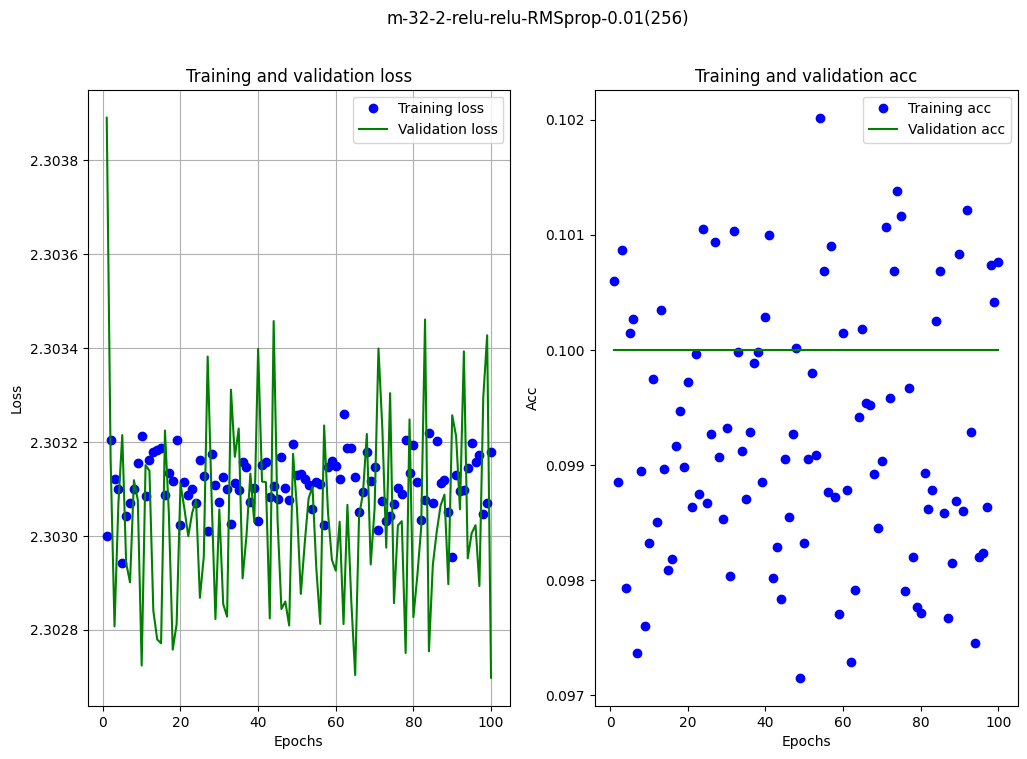

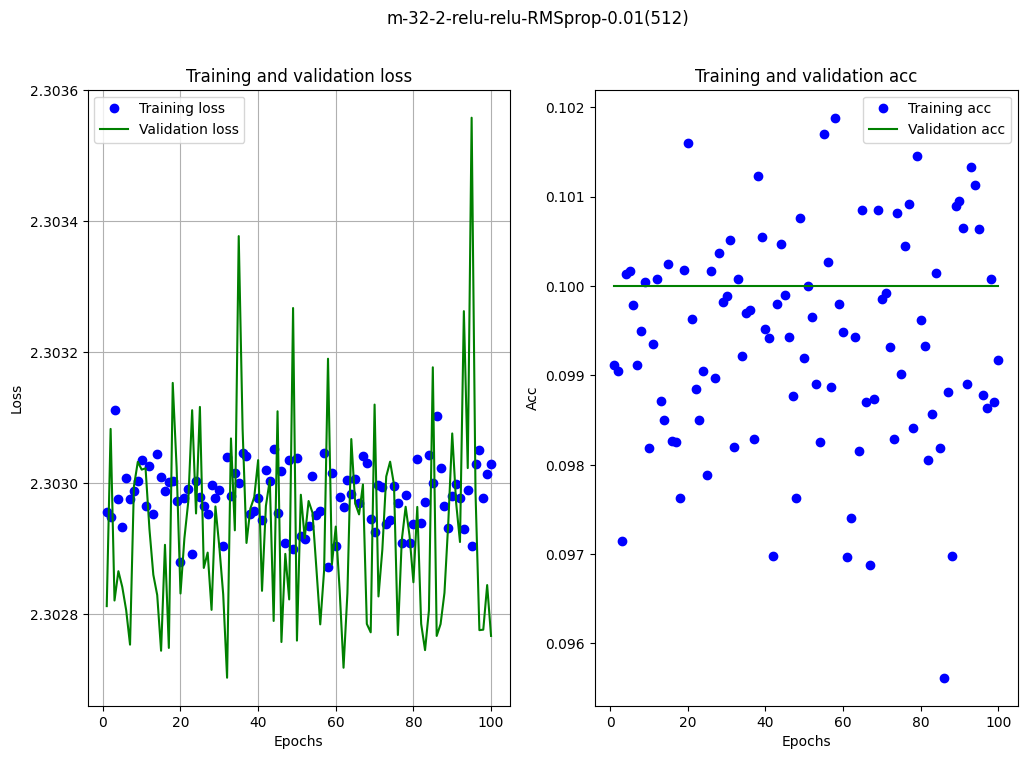

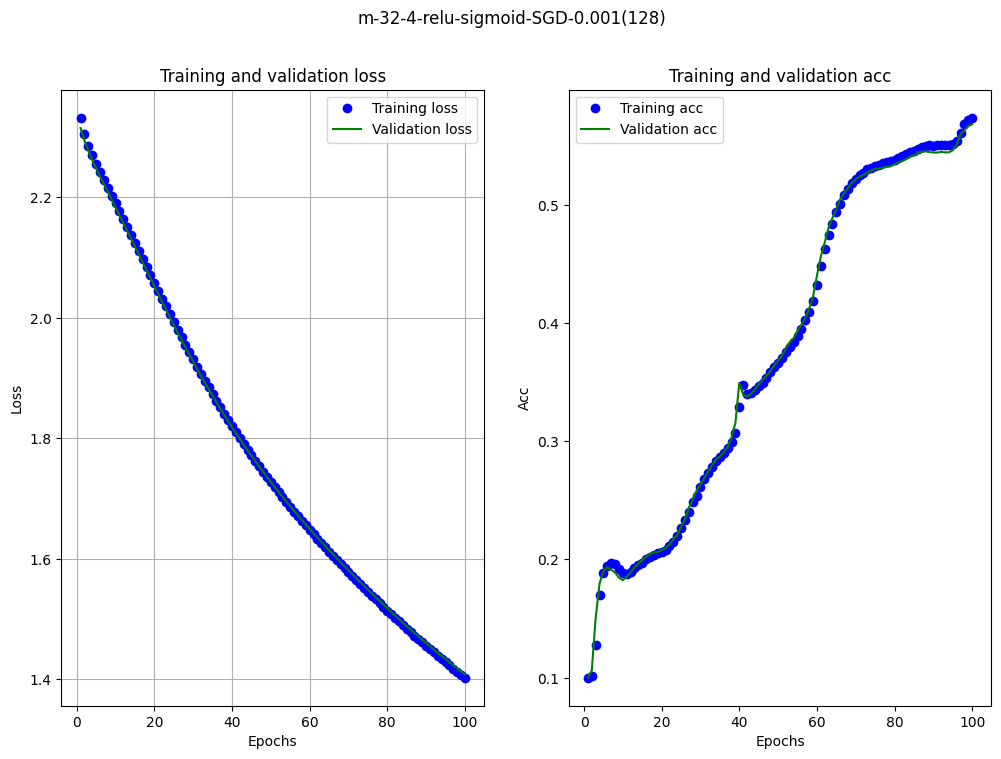

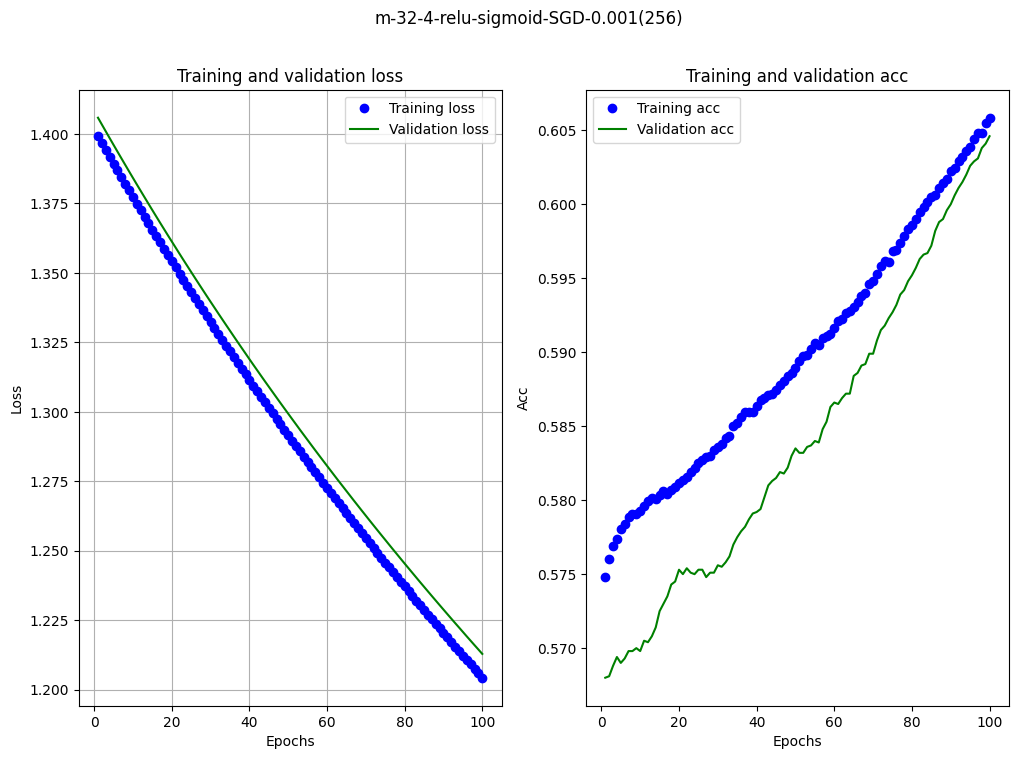

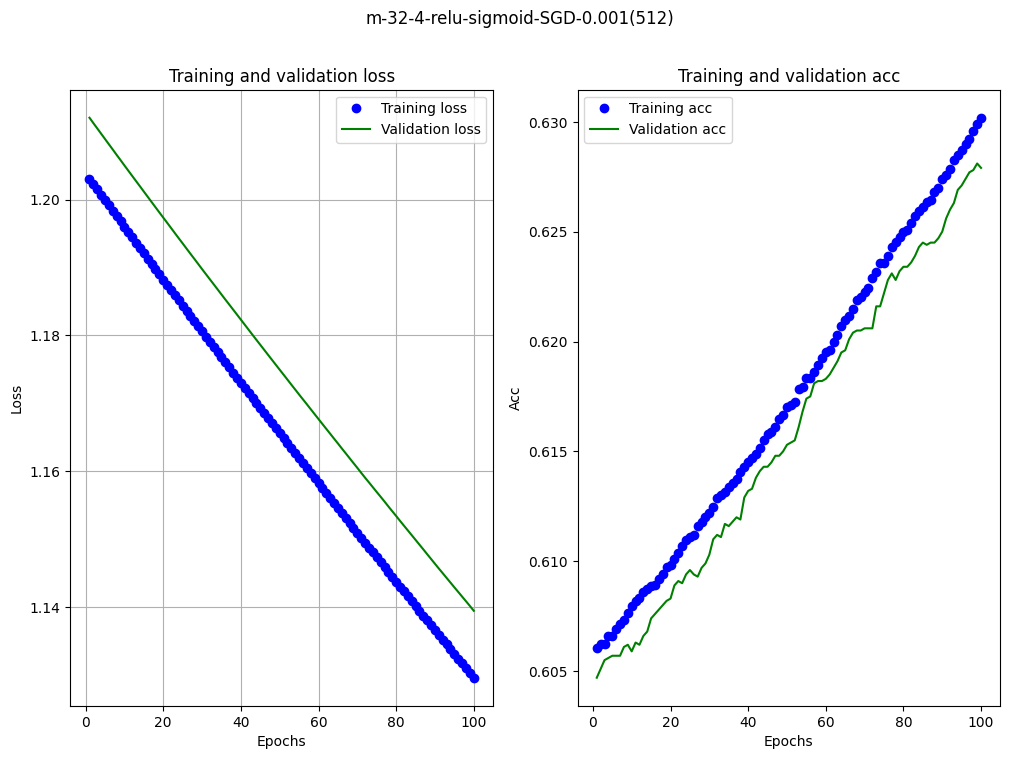

In [49]:
for model in history:
    history_dict = history[model].history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']   

    draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=model)


Висновки: ....

+ ....

In [ ]:
#